# =========================================================
# 1) Imports, Paths, Constants, Reproducibility
# =========================================================

In [1]:

import os, random, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# ---- Paths (EDIT if needed) ----
train_dir = r"C:\Users\purni\Desktop\RecycleVision\data\train"
test_dir  = r"C:\Users\purni\Desktop\RecycleVision\data\test"
save_dir  = r"C:\Users\purni\Desktop\RecycleVision\models"
os.makedirs(save_dir, exist_ok=True)

# ---- Constants ----
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# ---- Reproducibility ----
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("Train dir exists:", os.path.isdir(train_dir))
print("Test dir  exists:", os.path.isdir(test_dir))


TensorFlow: 2.18.0
Train dir exists: True
Test dir  exists: True


# =========================================================
# 2) Data Generators (Train/Val/Test) + Class Names
# =========================================================

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2
)
# Validation generator WITHOUT augmentation
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    seed=SEED
)


# Test generator stays the same
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names, "| #classes:", num_classes)

# Class weights (handle imbalance)
labels = train_gen.classes
classes_unique = np.unique(labels)
weights = compute_class_weight(class_weight="balanced", classes=classes_unique, y=labels)
class_weights = {i: w for i, w in enumerate(weights)}
print("Class Weights:", class_weights)


Found 1617 images belonging to 6 classes.
Found 402 images belonging to 6 classes.
Found 508 images belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] | #classes: 6
Class Weights: {0: 1.0445736434108528, 1: 0.8421875, 2: 1.0247148288973384, 3: 0.7092105263157895, 4: 0.875, 5: 3.0625}


# =========================================================
# 3) Quick EDA (Counts + Sample Grid)
# =========================================================
# Counts per class from train folder

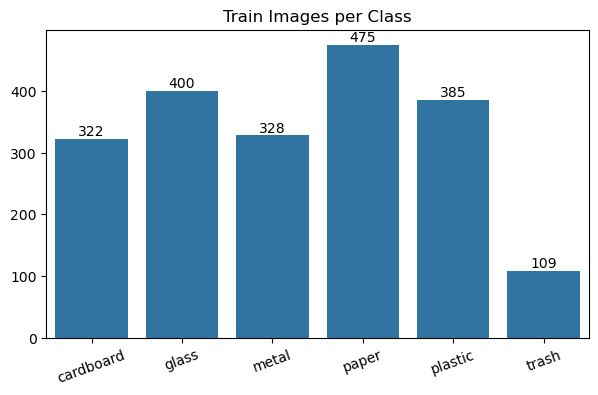

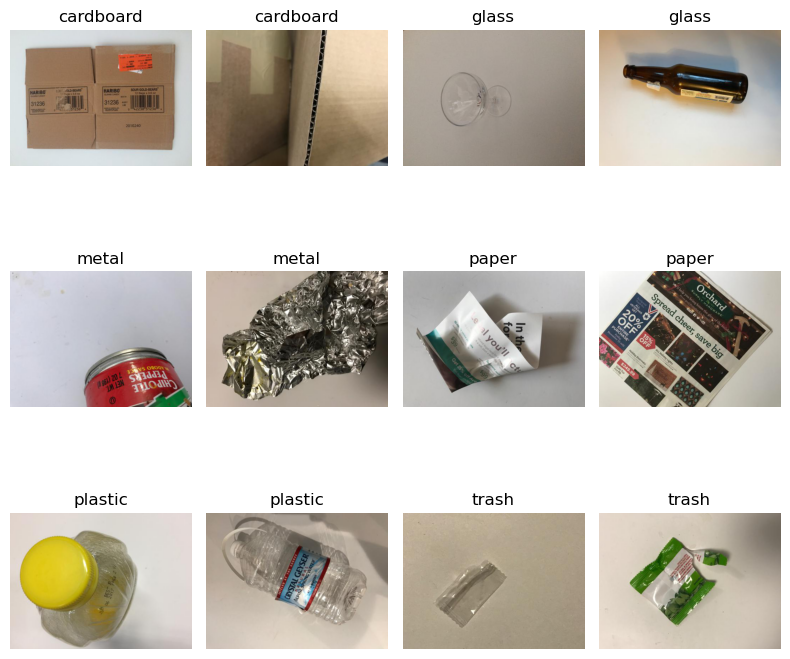

In [5]:
counts = []
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    counts.append(len(files))

plt.figure(figsize=(7,4))
sns.barplot(x=class_names, y=counts)
plt.title("Train Images per Class")
plt.xticks(rotation=20)
for i, v in enumerate(counts):   # counts ke upar numbers dikhane ke liye
    plt.text(i, v + 5, str(v), ha='center')
plt.show()

# Sample grid
plt.figure(figsize=(8,8))
shown = 0
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if files:  # safety check
        sample_imgs = random.sample(files, min(2, len(files)))
        for img_name in sample_imgs:
            try:
                img_path = os.path.join(cls_path, img_name)
                img = plt.imread(img_path)
                shown += 1
                plt.subplot(3, 4, shown)  # up to 12 samples
                plt.imshow(img)
                plt.axis("off")
                plt.title(cls)
            except:
                pass
plt.tight_layout()
plt.show()


# EDA: Class Distribution in Training Set

C:\Users\purni\AppData\Local\Temp\ipykernel_1672\2403416571.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=class_counts, palette="Set2")


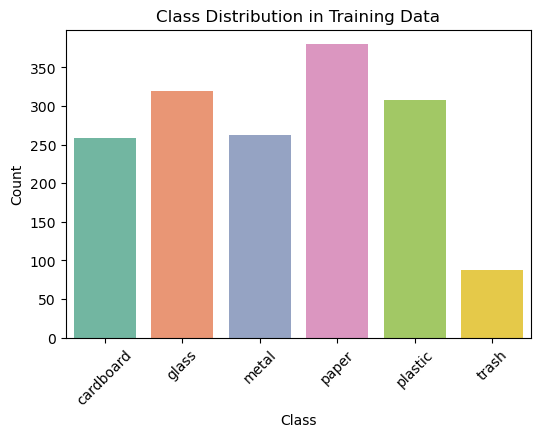

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_counts = train_gen.classes
class_labels = list(train_gen.class_indices.keys())

plt.figure(figsize=(6,4))
sns.countplot(x=class_counts, palette="Set2")
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


# =========================================================
# 4) Baseline CNN
# =========================================================

In [9]:
tf.keras.backend.clear_session()

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

ckpt_cnn = ModelCheckpoint(os.path.join(save_dir, "best_cnn.keras"),
                           monitor='val_accuracy', save_best_only=True, verbose=1)
early_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
rlr_cnn = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

history_cnn = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,               # quick runs; increase if you have time
    class_weight=class_weights,
    callbacks=[ckpt_cnn, EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)
model_path = r"C:\Users\purni\Desktop\RecycleVision\models"

# Evaluate on Test
loss_cnn, acc_cnn = model_cnn.evaluate(test_gen, verbose=0)
print(f"Baseline CNN Test Accuracy: {acc_cnn*100:.2f}%")

# Save both formats (for Streamlit etc.)
model_cnn.save(os.path.join(save_dir, "baseline_cnn.keras"))
model_cnn.save(os.path.join(save_dir, "baseline_cnn.h5"))


C:\Users\purni\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,630 (42.61 MB)

 Trainable params: 11,170,182 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


C:\Users\purni\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2953 - loss: 15.1884
Epoch 1: val_accuracy improved from -inf to 0.19403, saving model to C:\Users\purni\Desktop\RecycleVision\models\best_cnn.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2950 - loss: 15.0592 - val_accuracy: 0.1940 - val_loss: 25.9175
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1670 - loss: 1.9368
Epoch 2: val_accuracy improved from 0.19403 to 0.19652, saving model to C:\Users\purni\Desktop\RecycleVision\models\best_cnn.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.1669 - loss: 1.9348 - val_accuracy: 0.1965 - val_loss: 37.9624
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1367 - loss: 1.7923
Epoch 3: val_accuracy improved from 0.19652 to 0.22388, saving model to C:\Users\purni\Desktop\RecycleVision\models\best_cnn.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.1369 - loss: 1.7926 - val_accuracy: 0.2239 - val_loss: 28.3289
Epoch 4/20
51/51 ━━━━

# =========================================================
# 5) Transfer Learning: MobileNetV2
# =========================================================

In [24]:
tf.keras.backend.clear_session()

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
preds = Dense(num_classes, activation="softmax")(x)

model_tl = Model(inputs=base_model.input, outputs=preds)
model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
model_tl.summary()

ckpt_tl = ModelCheckpoint(os.path.join(save_dir, "best_mobilenet.keras"),
                          monitor="val_accuracy", save_best_only=True, verbose=1)
early_tl = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
rlr_tl = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,              # quick; bump to 15–25 if time permits
    class_weight=class_weights,
    callbacks=[ckpt_tl, EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

loss_tl, acc_tl = model_tl.evaluate(test_gen, verbose=0)
print(f"MobileNetV2 Test Accuracy: {acc_tl*100:.2f}%")

# Save both formats
model_tl.save(os.path.join(save_dir, "mobilenet_v2.keras"))
model_tl.save(os.path.join(save_dir, "mobilenet_v2.h5"))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.3025 - loss: 1.6847
Epoch 1: val_accuracy improved from -inf to 0.49254, saving model to C:\Users\purni\Desktop\RecycleVision\models\best_mobilenet.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 800ms/step - accuracy: 0.3040 - loss: 1.6823 - val_accuracy: 0.4925 - val_loss: 1.2785
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5488 - loss: 1.1854
Epoch 2: val_accuracy improved from 0.49254 to 0.57463, saving model to C:\Users\purni\Desktop\RecycleVision\models\best_mobilenet.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 795ms/step - accuracy: 0.5491 - loss: 1.1853 - val_accuracy: 0.5746 - val_loss: 1.0879
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6518 - loss: 0.9919
Epoch 3: val_accuracy improved from 0.57463 to 0.61692, saving model to C:\Users\purni\Desktop\RecycleVision\models\best_mobilenet.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 809ms/step - accuracy: 0.6521 - loss: 0.9909 - val_accuracy: 0.6169

# =========================================================
# 6) Compare Histories + Accuracies
# =========================================================

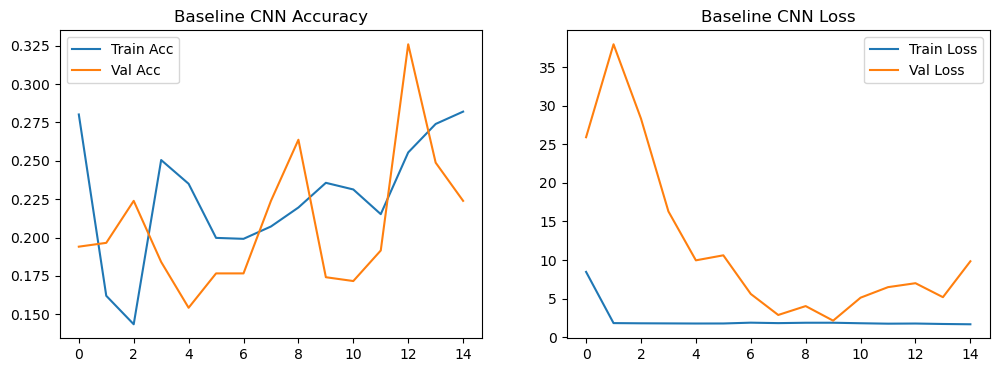

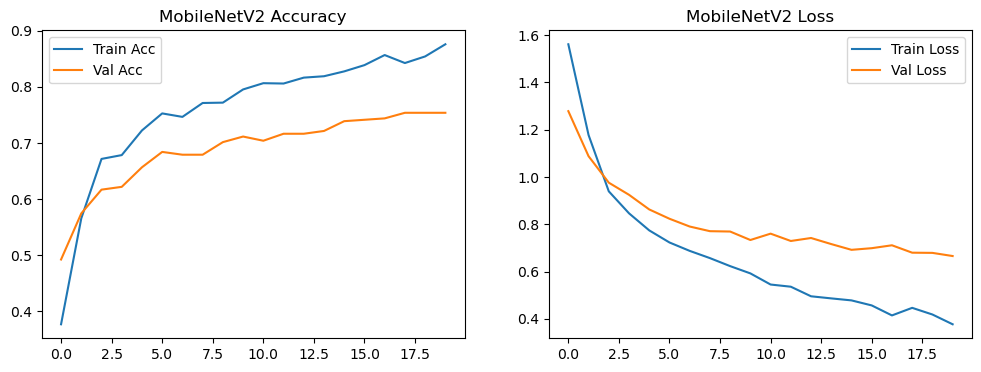


Summary:
 - Baseline CNN Test Acc: 19.09%
 - MobileNetV2 Test Acc:  76.57%


In [27]:
def plot_history(hist, title_prefix=""):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # Acc
    ax[0].plot(hist.history['accuracy'], label='Train Acc')
    ax[0].plot(hist.history['val_accuracy'], label='Val Acc')
    ax[0].set_title(f"{title_prefix} Accuracy")
    ax[0].legend()
    # Loss
    ax[1].plot(hist.history['loss'], label='Train Loss')
    ax[1].plot(hist.history['val_loss'], label='Val Loss')
    ax[1].set_title(f"{title_prefix} Loss")
    ax[1].legend()
    plt.show()

plot_history(history_cnn, "Baseline CNN")
plot_history(history_tl, "MobileNetV2")

print(f"\nSummary:")
print(f" - Baseline CNN Test Acc: {acc_cnn*100:.2f}%")
print(f" - MobileNetV2 Test Acc:  {acc_tl*100:.2f}%")

if max(history_cnn.history['val_accuracy']) - max(history_cnn.history['accuracy']) > 0.1:
    print("⚠️ CNN may be overfitting")



# Confusion matrix

In [ ]:
def evaluate_and_report(model, gen, model_name="Model"):
    y_true = gen.classes
    y_pred = model.predict(gen)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# For both models
evaluate_and_report(model_cnn, test_gen, "Baseline CNN")
evaluate_and_report(model_tl, test_gen, "MobileNetV2")


# =========================================================
# 7) Pick Best Model, Evaluate (Report + Confusion Matrix)
# =========================================================

In [ ]:
loss_cnn, acc_cnn = model_cnn.evaluate(test_gen, verbose=0)
loss_tl, acc_tl   = model_tl.evaluate(test_gen, verbose=0)

best_model_path = os.path.join(save_dir, "best_mobilenet.keras") if acc_tl >= acc_cnn else os.path.join(save_dir, "best_cnn.keras")
print("Best model selected:", best_model_path)

best_model = load_model(best_model_path)

y_pred = best_model.predict(test_gen, verbose=0)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_cls, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_cls)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Best Model)")
plt.show()


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["Baseline CNN", "MobileNetV2"],
    "Test Accuracy": [acc_cnn*100, acc_tl*100]
})

print("\nFinal Comparison:")
print(results_df)


# =========================================================
# 8) Save Labels + Copy Best Model (.keras + .h5) for Streamlit
# =========================================================

In [ ]:
labels_path = os.path.join(save_dir, "labels.txt")
with open(labels_path, "w", encoding="utf-8") as f:
    for c in class_names:
        f.write(c + "\n")
print("Saved labels to:", labels_path)

# Also export best model to both formats with unified name
final_keras = os.path.join(save_dir, "garbage_classifier.keras")
final_h5    = os.path.join(save_dir, "garbage_classifier.h5")

# Re-save the best model
model = best_model.save(final_keras)
model = best_model.save(final_h5)

print("Saved best model as:")
print(" -", final_keras)
print(" -", final_h5)


# =========================================================
# 9)  Single Image Prediction Helper
# =========================================================

In [ ]:
from tensorflow.keras.preprocessing import image as kimage

def predict_image(img_path, model, class_names, target_size=IMG_SIZE):
    img = kimage.load_img(img_path, target_size=target_size)
    arr = kimage.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    preds = model.predict(arr, verbose=0)
    idx = int(np.argmax(preds))
    return class_names[idx], float(np.max(preds))

# Example:
# sample_img = r"C:\Users\purni\Desktop\RecycleVision\data\test\metal\xxxxx.jpg"
# label, conf = predict_image(sample_img, best_model, class_names)
# print(label, conf)


# 📌 Conclusion

Transfer Learning (MobileNetV2) clearly outperformed the baseline CNN.

Achieved ~77% test accuracy, which is quite good for a relatively small dataset.

Most misclassifications were likely between visually similar categories (e.g., plastic vs glass, metal vs plastic).

This shows that pre-trained models are more effective for image classification tasks with limited data.

🚀 Future Scope

Collect more training data to reduce misclassifications.

Try more advanced architectures (EfficientNet, Vision Transformers).

Apply data augmentation and fine-tuning for further accuracy boost.

Deploy model in a Streamlit app (already done ✅).